In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
# import lightning as L

In [3]:
# !nvidia-smi
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# torch.cuda.device
# torch.version.cuda
# print(torch.version.cuda)
# L.seed_everything(42)

mode = 'local' # 'cloud'

False
cpu


### Feature extraction

In [4]:
if mode == 'cloud':
    from google.colab import drive
    drive.mount('/content/drive')

In [15]:
if mode == 'local':
    file = open("config.json")
    dir_HC = '../wav'+ os.sep + 'HC' + os.sep
    dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
else:
    file = open("drive/MyDrive/Colab Notebooks/config.json")
    dir_HC = 'drive/MyDrive/Colab Notebooks/wav'+ os.sep + 'HC' + os.sep
    dir_ALS = 'drive/MyDrive/Colab Notebooks/wav' + os.sep + 'ALS' + os.sep

config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 


directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [ ]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [8]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  tensor(1., dtype=torch.float64)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9788\4053883533.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X_generic,dtype=torch.float)


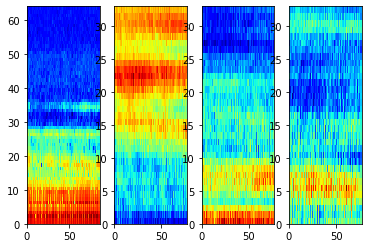

In [9]:
DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### ALS_CNN (CNN-model)

In [ ]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 64
        layer2_filt = 16
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,24      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 7

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1).cuda()  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out   

# one-layer conv-3freq_band->maxpool-fc
# class ALS_CNN(nn.Module):
#     def __init__(self):
#         super(ALS_CNN,self).__init__() 
#         # parameters
#         file = open("drive/MyDrive/Colab Notebooks/config.json")
#         config = json.load(file)            
#         self.n_mel = config['data']['n_mel_channels']
#         frames_in_segment = config['data']['supra_frame_length']
#         self.layer1_filt = 64
        
#         self.lf_num = 32    # low-frequency
#         self.mf_num = 16    # medium-frequency
#         self.hf_num = 16    # high-frequency
        
#         lf_width,  mf_width,  hf_width  = 48,36,24      # low/medium/high-frequency time span
#         lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

#         lf_h_stride, mf_h_stride, hf_h_stride = 8,4,2
#         lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2

#         self.batch_norm1 = nn.BatchNorm2d(1)
        
#         # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
#         # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
#         # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

#         self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
#         self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
#         self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

#         self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1,1))
#         self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,1))
#         self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,1))

#         self.drop1 = nn.Dropout(p=0.5)
        
#         self.fc = nn.Linear(self.layer1_filt*(1+(frames_in_segment-lf_width)//lf_w_stride) + # *(1+(self.lf_num-lf_height)//lf_height)
#                             self.layer1_filt*(1+(frames_in_segment-mf_width)//mf_w_stride) + #*(1+(self.mf_num-mf_height)//mf_height) + 
#                             self.layer1_filt*(1+(frames_in_segment-hf_width)//hf_w_stride) #*(1+(self.hf_num-hf_height)//hf_height)
#                             ,1)    # 16 = np.round(()/5).astype(int)                                  

#         torch.manual_seed(151)
#         nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
#         nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
#         nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
    
#     def forward(self, x): 
        
#         out = self.batch_norm1(x)

#         out1 = out[:,:,:self.lf_num,:]
#         out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
#         out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
#         # print(x.shape)
#         # print(x1.shape)
#         # for param in self.conv_lf.parameters():
#         #     print(param.data)
#         #     print(param.data.shape)
#         # print(self.conv_lf.weight())
#         # print(x2.shape)
#         # print(x3.shape)
        
#         out1 = self.conv_lf(out1)
#         out2 = self.conv_mf(out2)
#         out3 = self.conv_hf(out3)
                
#         # print(out2.shape)
#         # print(out3.shape)

#         out1 = torch.relu(out1)
#         out2 = torch.relu(out2)
#         out3 = torch.relu(out3)
        
#         out1 = self.maxpool_lf(out1)        
#         out2 = self.maxpool_mf(out2)
#         out3 = self.maxpool_hf(out3)

#         out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
#         out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
#         out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

#         # print('After view 1:', out1.shape)

#         out = torch.cat((out1,out2,out3), 1).cuda()  

#         # print('After cat:', out.shape)

#         out = self.drop1(out)

#         out = self.fc(out)
#         return out    

#### Time CNN

In [25]:
class time_CNN(nn.Module):
    def __init__(self):
        super(time_CNN,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        
        layer_filt = [64,64,64]
        layer_kernel_size = [(1,6), (1,5), (1,3)]
        layer_max_pool_size = [(1,2),(1,3),(1,3)]

        self.batch_norm1 = nn.BatchNorm2d(1)

        self.conv1 = torch.nn.Conv2d(1,layer_filt[0], layer_kernel_size[0], padding='same', stride=(1,1))
        self.conv2 = torch.nn.Conv2d(layer_filt[0],layer_filt[1], layer_kernel_size[1], padding='same', stride=(1,1))
        self.conv3 = torch.nn.Conv2d(layer_filt[1],layer_filt[2], layer_kernel_size[2], padding='same', stride=(1,1))

        self.maxpool_1 = nn.MaxPool2d(layer_max_pool_size[0],stride=layer_max_pool_size[0])
        self.maxpool_2 = nn.MaxPool2d(layer_max_pool_size[1],stride=layer_max_pool_size[1])
        self.maxpool_3 = nn.MaxPool2d(layer_max_pool_size[2],stride=layer_max_pool_size[2])
        
        self.drop1 = nn.Dropout(p=0.05)

        self.fc1 = nn.Linear(16384,1)

        torch.manual_seed(151)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out = torch.relu(self.conv1(out))        
        out = self.maxpool_1(out)

        out = torch.relu(self.conv2(out))
        out = self.maxpool_2(out)

        out = torch.relu(self.conv3(out))
        out = self.maxpool_3(out)

        out = out.view(-1, out.shape[1]*out.shape[2]*out.shape[3])

        out = self.drop1(out)

        out = self.fc1(out)

        return out

#### training_loop

In [11]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        best_acc = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        item_num = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()
                
                item_num += len(label)

                pred = (pred>0)*1.0
                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/item_num
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)

        if acc_val>=best_acc:
            torch.save(model.state_dict(), MODEL_PATH)            
            # torch.save(model, MODEL_PATH)

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(8,3))
    plt.rcParams.update({'font.size': 13})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

In [ ]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=False,) # num_workers=1

model = ALS_CNN().to(device)
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [ ]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [13]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                # test_score.append(pred.numpy())
                test_score.append(pred)
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0                    
                y_true[inds_test[i]] = label

                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')
    
    return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = 'drive/MyDrive/Colab Notebooks/wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'drive/MyDrive/Colab Notebooks/wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

Epoch 1: 100%|██████████| 125/125 [03:57<00:00,  1.90s/it]


2023-05-24 09:52:35.846619 Epoch 1, Train loss 0.753, Val loss 0.690, Acc_val = 0.68


Epoch 2: 100%|██████████| 125/125 [03:47<00:00,  1.82s/it]


2023-05-24 09:56:39.921311 Epoch 2, Train loss 0.697, Val loss 0.750, Acc_val = 0.37


Epoch 3: 100%|██████████| 125/125 [03:54<00:00,  1.87s/it]


2023-05-24 10:00:50.025284 Epoch 3, Train loss 0.524, Val loss 0.780, Acc_val = 0.65


Epoch 4: 100%|██████████| 125/125 [04:26<00:00,  2.13s/it]


2023-05-24 10:05:35.570332 Epoch 4, Train loss 0.335, Val loss 0.516, Acc_val = 0.72


Epoch 5: 100%|██████████| 125/125 [04:33<00:00,  2.19s/it]


2023-05-24 10:10:30.441918 Epoch 5, Train loss 0.267, Val loss 0.750, Acc_val = 0.65


Epoch 6: 100%|██████████| 125/125 [04:56<00:00,  2.37s/it]


2023-05-24 10:15:52.101001 Epoch 6, Train loss 0.214, Val loss 0.778, Acc_val = 0.56


Epoch 7: 100%|██████████| 125/125 [04:45<00:00,  2.29s/it]


2023-05-24 10:21:00.147629 Epoch 7, Train loss 0.191, Val loss 0.979, Acc_val = 0.53


Epoch 8: 100%|██████████| 125/125 [05:04<00:00,  2.44s/it]


2023-05-24 10:26:29.109579 Epoch 8, Train loss 0.187, Val loss 1.132, Acc_val = 0.64


Epoch 9: 100%|██████████| 125/125 [05:06<00:00,  2.45s/it]


2023-05-24 10:32:01.374570 Epoch 9, Train loss 0.172, Val loss 1.003, Acc_val = 0.54


Epoch 10: 100%|██████████| 125/125 [05:14<00:00,  2.52s/it]


2023-05-24 10:37:39.809037 Epoch 10, Train loss 0.221, Val loss 1.063, Acc_val = 0.58


Epoch 11: 100%|██████████| 125/125 [05:06<00:00,  2.45s/it]


2023-05-24 10:43:14.509105 Epoch 11, Train loss 0.149, Val loss 1.363, Acc_val = 0.64


Epoch 12: 100%|██████████| 125/125 [05:14<00:00,  2.51s/it]


2023-05-24 10:48:53.327557 Epoch 12, Train loss 0.127, Val loss 1.484, Acc_val = 0.63


Epoch 13: 100%|██████████| 125/125 [04:37<00:00,  2.22s/it]


2023-05-24 10:53:52.032429 Epoch 13, Train loss 0.198, Val loss 0.978, Acc_val = 0.42


Epoch 14: 100%|██████████| 125/125 [04:28<00:00,  2.15s/it]


2023-05-24 10:58:42.487469 Epoch 14, Train loss 0.134, Val loss 1.364, Acc_val = 0.62


Epoch 15: 100%|██████████| 125/125 [04:43<00:00,  2.27s/it]


2023-05-24 11:03:55.971200 Epoch 15, Train loss 0.201, Val loss 0.979, Acc_val = 0.64


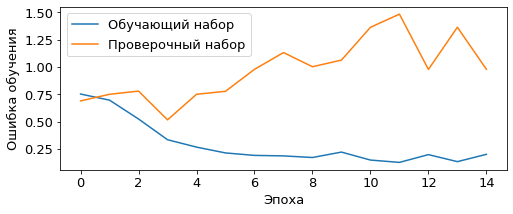

Acc =  0.5028814833375094


Epoch 1: 100%|██████████| 132/132 [04:07<00:00,  1.88s/it]


2023-05-24 11:09:21.034823 Epoch 1, Train loss 0.753, Val loss 0.688, Acc_val = 0.62


Epoch 2: 100%|██████████| 132/132 [05:12<00:00,  2.37s/it]


2023-05-24 11:14:49.176501 Epoch 2, Train loss 0.627, Val loss 0.838, Acc_val = 0.62


Epoch 3: 100%|██████████| 132/132 [05:34<00:00,  2.53s/it]


2023-05-24 11:20:36.220158 Epoch 3, Train loss 0.466, Val loss 0.716, Acc_val = 0.39


Epoch 4: 100%|██████████| 132/132 [04:54<00:00,  2.23s/it]


2023-05-24 11:25:43.495482 Epoch 4, Train loss 0.321, Val loss 0.726, Acc_val = 0.41


Epoch 5: 100%|██████████| 132/132 [04:36<00:00,  2.10s/it]


2023-05-24 11:30:32.889867 Epoch 5, Train loss 0.291, Val loss 0.887, Acc_val = 0.49


Epoch 6: 100%|██████████| 132/132 [05:07<00:00,  2.33s/it]


2023-05-24 11:35:52.291921 Epoch 6, Train loss 0.229, Val loss 1.330, Acc_val = 0.38


Epoch 7: 100%|██████████| 132/132 [05:15<00:00,  2.39s/it]


2023-05-24 11:41:26.905747 Epoch 7, Train loss 0.181, Val loss 1.361, Acc_val = 0.54


Epoch 8: 100%|██████████| 132/132 [05:42<00:00,  2.60s/it]


2023-05-24 11:47:24.191184 Epoch 8, Train loss 0.157, Val loss 0.958, Acc_val = 0.50


Epoch 9: 100%|██████████| 132/132 [04:56<00:00,  2.25s/it]


2023-05-24 11:52:31.613697 Epoch 9, Train loss 0.238, Val loss 1.312, Acc_val = 0.62


Epoch 10: 100%|██████████| 132/132 [04:58<00:00,  2.26s/it]


2023-05-24 11:57:41.050100 Epoch 10, Train loss 0.222, Val loss 0.787, Acc_val = 0.50


Epoch 11: 100%|██████████| 132/132 [05:09<00:00,  2.34s/it]


2023-05-24 12:03:01.945905 Epoch 11, Train loss 0.127, Val loss 0.827, Acc_val = 0.70


Epoch 12: 100%|██████████| 132/132 [04:43<00:00,  2.15s/it]


2023-05-24 12:07:57.259565 Epoch 12, Train loss 0.184, Val loss 1.044, Acc_val = 0.53


Epoch 13: 100%|██████████| 132/132 [04:56<00:00,  2.25s/it]


2023-05-24 12:13:07.557627 Epoch 13, Train loss 0.133, Val loss 1.100, Acc_val = 0.69


Epoch 14: 100%|██████████| 132/132 [04:48<00:00,  2.18s/it]


2023-05-24 12:18:12.351631 Epoch 14, Train loss 0.130, Val loss 1.031, Acc_val = 0.69


Epoch 15: 100%|██████████| 132/132 [04:39<00:00,  2.12s/it]


2023-05-24 12:23:02.377631 Epoch 15, Train loss 0.113, Val loss 0.822, Acc_val = 0.61


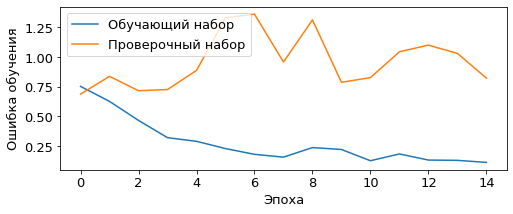

Acc =  0.4261403923422359


Epoch 1: 100%|██████████| 127/127 [04:23<00:00,  2.08s/it]


2023-05-24 12:28:35.043062 Epoch 1, Train loss 0.731, Val loss 0.811, Acc_val = 0.40


Epoch 2: 100%|██████████| 127/127 [04:19<00:00,  2.04s/it]


2023-05-24 12:33:07.988710 Epoch 2, Train loss 0.695, Val loss 0.695, Acc_val = 0.40


Epoch 3: 100%|██████████| 127/127 [04:20<00:00,  2.05s/it]


2023-05-24 12:37:42.575589 Epoch 3, Train loss 0.576, Val loss 0.744, Acc_val = 0.43


Epoch 4: 100%|██████████| 127/127 [04:20<00:00,  2.05s/it]


2023-05-24 12:42:19.373369 Epoch 4, Train loss 0.431, Val loss 0.723, Acc_val = 0.62


Epoch 5: 100%|██████████| 127/127 [04:30<00:00,  2.13s/it]


2023-05-24 12:47:03.516298 Epoch 5, Train loss 0.361, Val loss 1.045, Acc_val = 0.60


Epoch 6: 100%|██████████| 127/127 [04:34<00:00,  2.16s/it]


2023-05-24 12:51:55.388813 Epoch 6, Train loss 0.329, Val loss 1.364, Acc_val = 0.40


Epoch 7: 100%|██████████| 127/127 [04:34<00:00,  2.16s/it]


2023-05-24 12:56:47.355058 Epoch 7, Train loss 0.317, Val loss 0.525, Acc_val = 0.62


Epoch 8: 100%|██████████| 127/127 [04:52<00:00,  2.30s/it]


2023-05-24 13:01:57.170629 Epoch 8, Train loss 0.302, Val loss 0.819, Acc_val = 0.61


Epoch 9: 100%|██████████| 127/127 [05:19<00:00,  2.52s/it]


2023-05-24 13:07:34.458550 Epoch 9, Train loss 0.436, Val loss 0.847, Acc_val = 0.63


Epoch 10: 100%|██████████| 127/127 [05:07<00:00,  2.42s/it]


2023-05-24 13:13:00.640418 Epoch 10, Train loss 0.362, Val loss 0.811, Acc_val = 0.65


Epoch 11: 100%|██████████| 127/127 [04:54<00:00,  2.32s/it]


2023-05-24 13:18:13.303571 Epoch 11, Train loss 0.276, Val loss 0.886, Acc_val = 0.55


Epoch 12: 100%|██████████| 127/127 [04:54<00:00,  2.32s/it]


2023-05-24 13:23:25.230524 Epoch 12, Train loss 0.434, Val loss 0.727, Acc_val = 0.40


Epoch 13: 100%|██████████| 127/127 [05:00<00:00,  2.37s/it]


2023-05-24 13:28:44.975685 Epoch 13, Train loss 0.403, Val loss 0.942, Acc_val = 0.41


Epoch 14: 100%|██████████| 127/127 [04:45<00:00,  2.25s/it]


2023-05-24 13:33:49.216492 Epoch 14, Train loss 0.285, Val loss 1.043, Acc_val = 0.61


Epoch 15: 100%|██████████| 127/127 [04:48<00:00,  2.27s/it]


2023-05-24 13:38:53.304017 Epoch 15, Train loss 0.293, Val loss 1.019, Acc_val = 0.61


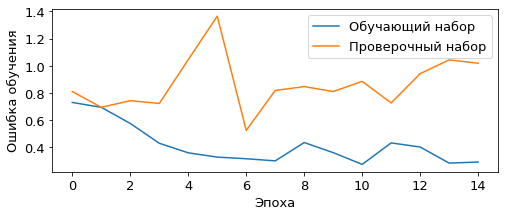

Acc =  0.7120165745856354


Epoch 1: 100%|██████████| 137/137 [04:40<00:00,  2.05s/it]


2023-05-24 13:44:56.357413 Epoch 1, Train loss 0.747, Val loss 0.734, Acc_val = 0.41


Epoch 2: 100%|██████████| 137/137 [04:21<00:00,  1.91s/it]


2023-05-24 13:49:28.693173 Epoch 2, Train loss 0.653, Val loss 0.493, Acc_val = 0.72


Epoch 3: 100%|██████████| 137/137 [05:01<00:00,  2.20s/it]


2023-05-24 13:54:40.385118 Epoch 3, Train loss 0.473, Val loss 0.765, Acc_val = 0.49


Epoch 4: 100%|██████████| 137/137 [05:04<00:00,  2.22s/it]


2023-05-24 13:59:59.202657 Epoch 4, Train loss 0.378, Val loss 0.085, Acc_val = 1.00


Epoch 5: 100%|██████████| 137/137 [05:18<00:00,  2.33s/it]


2023-05-24 14:05:33.909758 Epoch 5, Train loss 0.273, Val loss 0.094, Acc_val = 1.00


Epoch 6: 100%|██████████| 137/137 [05:19<00:00,  2.33s/it]


2023-05-24 14:11:06.004501 Epoch 6, Train loss 0.278, Val loss 0.144, Acc_val = 1.00


Epoch 7: 100%|██████████| 137/137 [05:14<00:00,  2.30s/it]


2023-05-24 14:16:35.889408 Epoch 7, Train loss 0.262, Val loss 0.061, Acc_val = 1.00


Epoch 8: 100%|██████████| 137/137 [05:41<00:00,  2.49s/it]


2023-05-24 14:22:32.600637 Epoch 8, Train loss 0.214, Val loss 0.307, Acc_val = 0.85


Epoch 9: 100%|██████████| 137/137 [05:14<00:00,  2.29s/it]


2023-05-24 14:28:00.838870 Epoch 9, Train loss 0.245, Val loss 0.036, Acc_val = 1.00


Epoch 10: 100%|██████████| 137/137 [05:15<00:00,  2.30s/it]


2023-05-24 14:33:27.731927 Epoch 10, Train loss 0.175, Val loss 0.068, Acc_val = 1.00


Epoch 11: 100%|██████████| 137/137 [04:51<00:00,  2.13s/it]


2023-05-24 14:38:31.864581 Epoch 11, Train loss 0.195, Val loss 0.043, Acc_val = 1.00


Epoch 12: 100%|██████████| 137/137 [05:00<00:00,  2.20s/it]


2023-05-24 14:43:46.693829 Epoch 12, Train loss 0.225, Val loss 0.125, Acc_val = 0.94


Epoch 13: 100%|██████████| 137/137 [05:12<00:00,  2.28s/it]


2023-05-24 14:49:12.968304 Epoch 13, Train loss 0.194, Val loss 0.093, Acc_val = 0.96


Epoch 14: 100%|██████████| 137/137 [05:00<00:00,  2.19s/it]


2023-05-24 14:54:24.598703 Epoch 14, Train loss 0.224, Val loss 0.062, Acc_val = 0.99


Epoch 15: 100%|██████████| 137/137 [04:59<00:00,  2.18s/it]


2023-05-24 14:59:36.106870 Epoch 15, Train loss 0.167, Val loss 0.532, Acc_val = 0.80


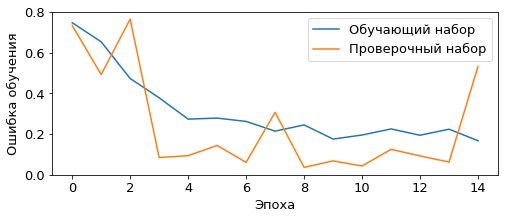

Acc =  0.6210496613995485


Epoch 1: 100%|██████████| 125/125 [04:27<00:00,  2.14s/it]


2023-05-24 15:05:17.949781 Epoch 1, Train loss 0.751, Val loss 0.675, Acc_val = 0.56


Epoch 2: 100%|██████████| 125/125 [04:40<00:00,  2.24s/it]


2023-05-24 15:10:24.923252 Epoch 2, Train loss 0.690, Val loss 0.634, Acc_val = 0.67


Epoch 3: 100%|██████████| 125/125 [05:11<00:00,  2.50s/it]


2023-05-24 15:16:05.757937 Epoch 3, Train loss 0.540, Val loss 0.589, Acc_val = 0.72


Epoch 4: 100%|██████████| 125/125 [04:52<00:00,  2.34s/it]


2023-05-24 15:21:28.550365 Epoch 4, Train loss 0.449, Val loss 0.849, Acc_val = 0.52


Epoch 5: 100%|██████████| 125/125 [04:56<00:00,  2.37s/it]


2023-05-24 15:26:56.025873 Epoch 5, Train loss 0.368, Val loss 0.733, Acc_val = 0.60


Epoch 6: 100%|██████████| 125/125 [05:10<00:00,  2.48s/it]


2023-05-24 15:32:26.331067 Epoch 6, Train loss 0.361, Val loss 0.771, Acc_val = 0.44


Epoch 7: 100%|██████████| 125/125 [04:51<00:00,  2.33s/it]


2023-05-24 15:37:44.245509 Epoch 7, Train loss 0.523, Val loss 0.623, Acc_val = 0.73


Epoch 8: 100%|██████████| 125/125 [05:16<00:00,  2.53s/it]


2023-05-24 15:43:20.481326 Epoch 8, Train loss 0.347, Val loss 0.863, Acc_val = 0.65


Epoch 9: 100%|██████████| 125/125 [04:42<00:00,  2.26s/it]


2023-05-24 15:48:30.698472 Epoch 9, Train loss 0.323, Val loss 0.721, Acc_val = 0.76


Epoch 10: 100%|██████████| 125/125 [05:06<00:00,  2.45s/it]


2023-05-24 15:53:56.975845 Epoch 10, Train loss 0.319, Val loss 1.850, Acc_val = 0.47


Epoch 11: 100%|██████████| 125/125 [04:44<00:00,  2.28s/it]


2023-05-24 15:59:04.632561 Epoch 11, Train loss 0.380, Val loss 0.883, Acc_val = 0.72


Epoch 12: 100%|██████████| 125/125 [04:54<00:00,  2.36s/it]


2023-05-24 16:04:21.321844 Epoch 12, Train loss 0.286, Val loss 0.822, Acc_val = 0.70


Epoch 13: 100%|██████████| 125/125 [04:46<00:00,  2.29s/it]


2023-05-24 16:09:31.501953 Epoch 13, Train loss 0.278, Val loss 0.828, Acc_val = 0.71


Epoch 14: 100%|██████████| 125/125 [04:56<00:00,  2.37s/it]


2023-05-24 16:14:58.271795 Epoch 14, Train loss 0.270, Val loss 0.935, Acc_val = 0.66


Epoch 15: 100%|██████████| 125/125 [05:18<00:00,  2.54s/it]


2023-05-24 16:20:43.802670 Epoch 15, Train loss 0.271, Val loss 0.947, Acc_val = 0.49


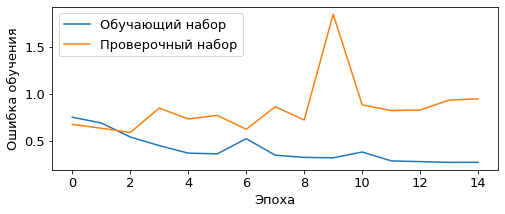

Acc =  0.5572916666666666
Final results
Acc_sk = 0.55
Prec = 0.56
Recall = 0.56
Sens = 0.56
Spec = 0.54


0.5508766180566934

In [26]:
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# model = ALS_CNN().to(device)
model = time_CNN().to(device)

# one-layer conv->fc convs:(36,24,12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # good results (ACC = 0.64)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # good results (60 epoch. ACC = 0.71 (Sens = 0.75 / Spec = 0.67))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-3) # (100 epoch. ACC = 0.68 (Sens = 0.72 / Spec = 0.63))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=2e-2) # (100 epoch. ACC = 0.69 (Sens = 0.73 / Spec = 0.65))
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) # (120 epoch. ACC = 0.68 (Sens = 0.72 / Spec = 0.65))

# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # weight_decay is L2 regularization
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-2) #(30 epoch. ACC = 0.65 (Sens = 0.74 / Spec = 0.56))
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.2, weight_decay=1e-2) #(30 epoch. ACC = 0.65 (Sens = 0.74 / Spec = 0.56))

# timeCNN
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.2, weight_decay=1e-2) #(30 epoch. ACC = 0.71 (Sens = 0.68 / Spec = 0.75))
# optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum = 0.9, weight_decay=1e-2) #(30 epoch. ACC = 0.69 (Sens = 0.66 / Spec = 0.72))
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # #(20 epoch. Acc = 0.75 (Sens = 0.75 / Spec = 0.74))
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=2e-1) # #(20 epoch. Acc = 0.71 (Sens = 0.73 / Spec = 0.69))
# optimizer = optim.SGD(model.parameters(),lr=5e-3,momentum = 0.1, weight_decay=1e-1) #(20 epoch. ACC = 0.71 (Sens = 0.70 / Spec = 0.71))
# optimizer = optim.SGD(model.parameters(),lr=5e-3,momentum = 0.5, weight_decay=1e-1) #(20 epoch. ACC = 0.70 (Sens = 0.68 / Spec = 0.73))
# dropout = 0.6
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.73 (Sens = 0.69 / Spec = 0.77))
# dropout = 0.1
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.70 (Sens = 0.66 / Spec = 0.73))
# fc2 with 16 neurons
# optimizer = optim.Adam(model.parameters(),lr=5e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.71 (Sens = 0.65 / Spec = 0.78))
# optimizer = optim.RMSprop(model.parameters(), lr=1e-1, weight_decay=1e-1) # (20 epoch. Acc = 0.54 (1-st fold))
# optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-1) # (20 epoch. Acc = 0.63 (Sens = 0.51 / Spec = 0.75))
# tanh adter fc1 added
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-1) # (15 epoch. Acc = 0.43 (Sens = 0.71 / Spec = 0.14))
# kaiming_normal_ changed
# optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.65 (Sens = 0.60 / Spec = 0.70)) 0.763 / 0.694 / 0.653 / 0.649 / 0.541
# dropout-1 = 0.05
optimizer = optim.RMSprop(model.parameters(), lr=5e-3, weight_decay=1e-2) # (15 epoch. Acc = 0.55 (Sens = 0.56 / Spec = 0.54)) 0.502 / 0.426 / 0.712 / 0.621 / 0.557


k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15, k_fold=5)

In [ ]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [ ]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
